# Model Training with nnfabrik

In [1]:
%load_ext autoreload
%autoreload 2

import cascade

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nnfabrik.builder import get_data, get_model, get_trainer

import datajoint as dj
dj.config["database.host"] = '134.76.19.44'
dj.config['nnfabrik.schema_name'] = "nnfabrik_neural_prediction_challenge"

from cascade.schemas.nnfabrik import Fabrikant, Model, Dataset, Trainer, Seed, TrainedModel

Connecting kwilleke@134.76.19.44:3306


In [2]:
Fabrikant()

fabrikant_name Name of the contributor that added this entry,full_name full name of the person,email e-mail address,affiliation conributor's affiliation (e.g. Sinz Lab),dj_username DataJoint username
kwilleke,,konstantin.willeke@gmail.com,sinzlab,kwilleke


# Initial Addition of Tables for the Schema

In [ ]:
Fabrikant().insert1(dict(fabrikant_name='kwilleke',
                         email="konstantin.willeke@gmail.com",
                         affiliation='sinzlab',
                         dj_username="kwilleke"))

In [ ]:
Seed().insert([{'seed':1000}])
Seed()

# Add Dataset

In [2]:
# the cascade mouse dataloader takes the files from the Preprocessed mouse table and stores them on the server under /data/mouse/toliaslab/static/. like the other datasets
filenames = ['static26645-2-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 'static26644-14-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip']

dataset_fn = 'cascade.datasets.static_loaders'
dataset_config = {'paths': filenames,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': True,
                 'batch_size': 128,
                 'exclude': None,
                 'file_tree': True,
                 'scale': 0.5
                 }

dataloaders = get_data(dataset_fn, dataset_config)

static26645-2-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6 exists already. Not unpacking static26645-2-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip
static26644-14-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6 exists already. Not unpacking static26644-14-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip


In [5]:
Dataset().add_entry(dataset_fn, dataset_config, dataset_comment="Both Test Scans, 72x128px, w/o behavior")

{'dataset_fn': 'cascade.datasets.static_loaders',
 'dataset_hash': '9483f97db6cca8f6c9c8c917eae046eb'}

In [6]:
b = next(iter(dataloaders["train"]["26644-14-17"]))

In [7]:
b.images.shape

torch.Size([128, 1, 72, 128])

# Add Model

In [15]:
# the grid mean predictor is not useable in the current neuralpredictors. I opened an issue about it.

model_fn = 'cascade.models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
               'stack': -1,
               'hidden_channels': 64,
               'depth_separable': True,
               #'grid_mean_predictor': {'type': 'cortex',
               # 'input_dimensions': 2,
               # 'hidden_layers': 0,
               # 'hidden_features': 30,
               # 'final_tanh': True},
               'init_sigma': 0.1,
               'init_mu_range': 0.3,
               'gauss_type': 'full',
               'gamma_input': 5.0968,
               'gamma_readout': 0.029,
               'hidden_kern': 15,
               'input_kern': 9,
               'hidden_dilation': 1,
               'layers': 5}

model = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders,
                  seed=1,)

In [19]:
Model().add_entry(model_fn, model_config, model_comment="Shans HiRes model")

{'model_fn': 'cascade.models.stacked_core_full_gauss_readout',
 'model_hash': 'c2dc75a58396ff8341f85a4278254670'}

# Add Trainer

In [20]:
trainer_fn = "cascade.training.standard_trainer"

trainer_config = {'max_iter': 100,
                 'verbose': False,
                 'lr_decay_steps': 4,
                 'avg_loss': False,
                 'lr_init': 0.009,
                 }

trainer = get_trainer(trainer_fn=trainer_fn, 
                     trainer_config=trainer_config)

In [21]:
Trainer().add_entry(trainer_fn, trainer_config, trainer_comment="color mei default trainer")

{'trainer_fn': 'cascade.training.standard_trainer',
 'trainer_hash': 'b4c0c7c93781ae3aa4b502cc9c925b82'}

# TrainedModel Table

In [3]:
TrainedModel()

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
cascade.models.stacked_core_full_gauss_readout,c2dc75a58396ff8341f85a4278254670,cascade.datasets.static_loaders,9483f97db6cca8f6c9c8c917eae046eb,cascade.training.standard_trainer,b4c0c7c93781ae3aa4b502cc9c925b82,1000,"color mei default trainer.Shans HiRes mdodel.Both Test Scans, 72x128px, w/o behavior",0.352859,=BLOB=,kwilleke,2021-12-18 05:11:56


# Train Model

In [ ]:
pop_key = dict(model_hash='c2dc75a58396ff8341f85a4278254670')
TrainedModel().populate(pop_key, display_progress=True)

In [38]:
dataloaders, model = (TrainedModel() & pop_key).load_model()

/data/mouse/toliaslab/static/static26645-2-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6 exists already. Not unpacking /data/mouse/toliaslab/static/static26645-2-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip
/data/mouse/toliaslab/static/static26644-14-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6 exists already. Not unpacking /data/mouse/toliaslab/static/static26644-14-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip


/notebooks/ml-utils/neuralpredictors/layers/cores/conv2d.py:163: UserWarning: group sparsity can not be calculated for the requested conv type. Hidden channels will not be regularized and gamma_hidden is ignored.
  warnings.warn("group sparsity can not be calculated for the requested conv type. Hidden channels will not be regularized and gamma_hidden is ignored.")
/notebooks/ml-utils/neuralpredictors/layers/readouts/base.py:62: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/notebooks/ml-utils/neuralpredictors/layers/readouts/base.py:79: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


In [39]:
# import the data quality metrics
from cascade.utility.measures import get_conservative_oracles, get_SNR, get_explainable_var, get_jackknife_oracles, get_avg_firing

# import model evaluation metrics
from cascade.utility.scores import get_signal_correlations, get_correlations, get_FEV, get_fraction_oracles

#### Building the oracle DataLoader

This dataloader will return all repeats of one oracle image in a single batch

In [40]:
dataset_fn = 'cascade.datasets.static_loaders'
dataset_config["return_test_sampler"] = True

oracle_dataloaders = get_data(dataset_fn, dataset_config)

/data/mouse/toliaslab/static/static26645-2-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6 exists already. Not unpacking /data/mouse/toliaslab/static/static26645-2-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip
/data/mouse/toliaslab/static/static26644-14-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6 exists already. Not unpacking /data/mouse/toliaslab/static/static26644-14-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip


In [41]:
def serialize_session_dict_into_df(session_dict, measure_attribute='score'):
    data_keys, values = [], []
    for key, unit_array in session_dict.items():
        for value in unit_array:
            data_keys.append(key)
            values.append(value)
    df = pd.DataFrame({'dataset':data_keys, measure_attribute:values})
    return df

# Conservative Oracle

In [42]:
sns.set_context("talk", font_scale=0.9)

In [43]:
c_oracles = get_conservative_oracles(oracle_dataloaders, as_dict=True, per_neuron=True)

df = serialize_session_dict_into_df(session_dict=c_oracles,
                                    measure_attribute="conservative oracle correlation"
                                   )

/notebooks/neural-prediction-challenge/cascade/utility/measures.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(repeated_inputs), np.array(repeated_outputs)


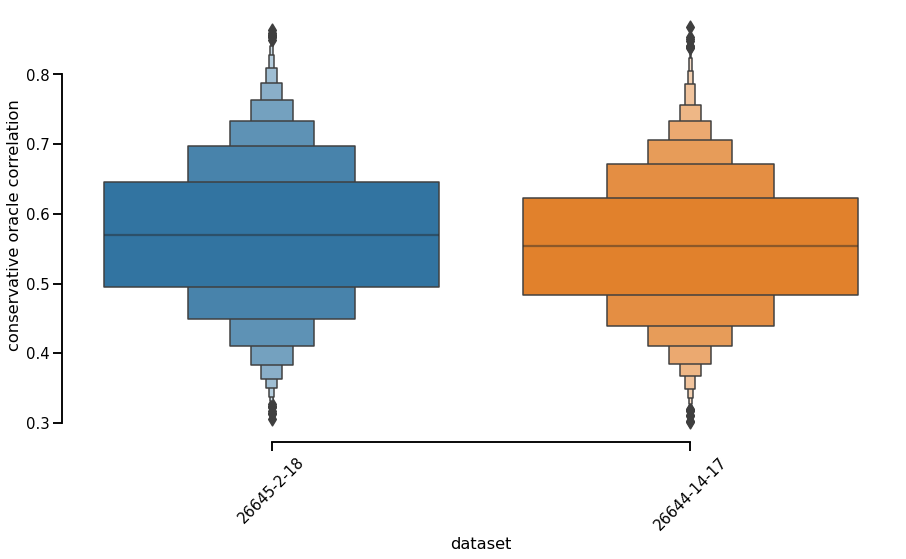

In [44]:
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="conservative oracle correlation", data=df, )
plt.xticks(rotation = 45);
sns.despine(trim=True)


# Test correlation

a.k.a single trial test correlation

In [45]:
test_corrs = get_correlations(model, oracle_dataloaders, device="cuda", as_dict=True)

df = serialize_session_dict_into_df(session_dict=test_corrs,
                                    measure_attribute="test correlation")

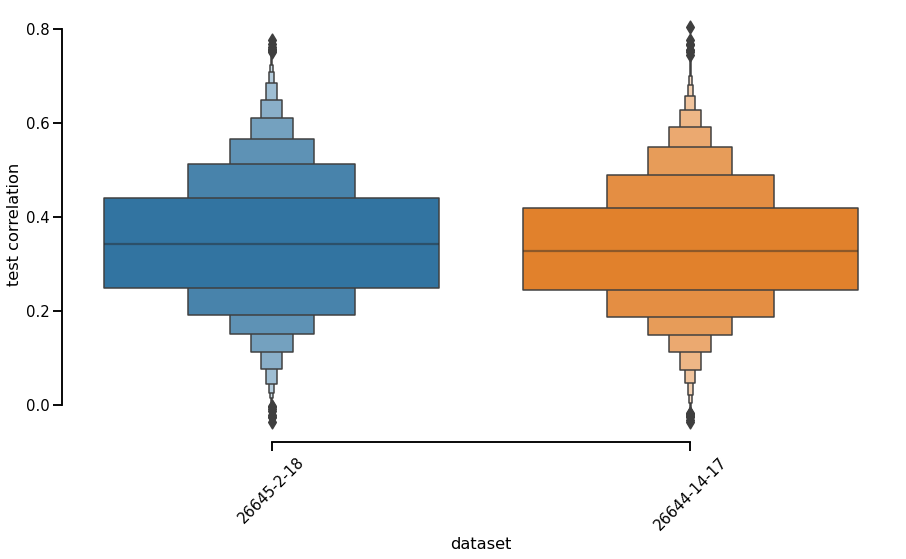

In [46]:
fig = plt.figure(figsize=(15,8))
sns.boxenplot(x="dataset", y="test correlation", data=df,)
plt.xticks(rotation = 45);
sns.despine(trim=True)